For HCP data Registration - get and save out transformations fMRI-> T1w -> MNI

In [ ]:
# use moition corrected data, save mean_fmri volume. 
import ants
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt
from nilearn import plotting
import subprocess
import shutil

# get subjects from subjects.txt:
subjects_file = r"D:\HCP_vessel_files\subjects.txt"

with open(subjects_file, "r") as f:
    subjects = [line.strip() for line in f if line.strip()]
print("Loaded", len(subjects), "subjects:")

# subjects = subjects[:10]

print(subjects)  


Loaded 190 subjects:
['100307', '101309', '102008', '102311', '103111', '103414', '103818', '105014', '107422', '108828', '109123', '110411', '111716', '113619', '113821', '113922', '114419', '115320', '116524', '118528', '118932', '120212', '121618', '123420', '124220', '124826', '127630', '128127', '129533', '130013', '132118', '133827', '136833', '137027', '137128', '137936', '138231', '140117', '140824', '142424', '142828', '143325', '144832', '145531', '146331', '146432', '148941', '150423', '150726', '151627', '153833', '154734', '154936', '155635', '156637', '158035', '159138', '161630', '161731', '162733', '163331', '164131', '165032', '167743', '168341', '169343', '169444', '170934', '172130', '172938', '173536', '175035', '177645', '178950', '179346', '180129', '180836', '180937', '181232', '183034', '185139', '186141', '187143', '187547', '188347', '189349', '191033', '191437', '191841', '192540', '192843', '194140', '194847', '195849', '197348', '198855', '199150', '199251'

In [2]:
for subjectid in subjects:
    file_path = fr"D:\hcp_processed\{subjectid}\motion_corrected\mean_fmri_registered_mni.nii.gz"
    if os.path.exists(file_path):
        print(f"Skipping {subjectid}, file already exists.")
        continue  # Skip this subject
    else:
        print(f"Processing {subjectid}...")
    # print(f"subject {subjectid}")

    output_dir = fr"D:\hcp_processed\{subjectid}\motion_corrected" 
    output_nifti = os.path.join(output_dir, f"{subjectid}_REST1_LR_mc.nii.gz") # motion corrected output

    fmri_img = nib.load(output_nifti)
    mean_data = np.mean(fmri_img.get_fdata(), axis=3)
    mean_img = nib.Nifti1Image(mean_data, fmri_img.affine)
    mean_img_path = fr"{output_dir}\mean_fmri.nii.gz"
    nib.save(mean_img, mean_img_path)

    # Load mean fMRI and subject's T1w image
    mean_fmri = ants.image_read(mean_img_path)
    t1_path = fr"D:\hcp_data\{subjectid}\T1w\T1w_acpc_dc_restore.nii.gz"
    t1_img = ants.image_read(t1_path)

    # Run rigid registration
    transform_dir = fr"D:\hcp_processed\{subjectid}\transforms" # output directory for transformations
    os.makedirs(transform_dir, exist_ok=True)

    reg = ants.registration(fixed=t1_img, 
                            moving=mean_fmri, 
                            type_of_transform='Rigid',
                            outprefix=os.path.join(transform_dir, "fMRI_to_T1w_"))  # <- here

    fwd_transform_paths = reg['fwdtransforms']

    # Save forward transforms (fMRI → T1w)
    # fwd_transform_paths = []  # <- List to hold new (permanent) paths
    # for i, tf in enumerate(reg['fwdtransforms']):
    #     # name = f"fMRI_to_T1w_transform_{i}" + (".mat" if tf.endswith(".mat") else ".nii.gz")
    #     # dest = os.path.join(transform_dir, name)
    #     # os.replace(tf, dest)
    #     # fwd_transform_paths.append(dest)  # <- Store new path
    #     ext = ".mat" if tf.endswith(".mat") else ".nii.gz"
    #     name = f"T1w_to_MNI_transform_{i}{ext}"
    #     dest = os.path.join(transform_dir, name)
    #     shutil.move(tf, dest)
    #     fwd_transform_paths_mni.append(dest)


    # Apply the transform to move fMRI → T1w space
    mean_fmri_registered = ants.apply_transforms(
        fixed=t1_img,
        moving=mean_fmri,
        transformlist=fwd_transform_paths,
        interpolator='linear'
    )

    assert isinstance(t1_img, ants.ANTsImage)
    assert isinstance(mean_fmri_registered, ants.ANTsImage)

    # Save registered mean fMRI
    registered_fmri_path = fr"{output_dir}\mean_fmri_registered_T1w.nii.gz"
    ants.image_write(mean_fmri_registered, registered_fmri_path)


    # is t1_path: t1_input = fr"C:\DocumentsPC\DATA\HCP\{subjectid}_3T_Structural_preproc\{subjectid}\T1w\T1w_acpc_dc_restore.nii.gz"
    t1_brain_output = fr"D:\hcp_processed\{subjectid}\T1w_brain.nii.gz"

    cmd = [
        "hd-bet",
        "-i", t1_path,
        "-o", t1_brain_output,
        "-device", "cpu",
        # "-mode", "fast"
        # "--save_mask"          # optional: save brain mask
    ]

    # Run the command

    try:
        subprocess.run(cmd, check=True, capture_output=True, text=True)
    except subprocess.CalledProcessError as e:
        print("STDOUT:\n", e.stdout)
        print("STDERR:\n", e.stderr)
##############################################3
    # register T1w -> MNI
    # MNI template: "C:\DocumentsPC\DATA\Templates\mni_template.nii"
    # Paths
    mni_path = r"D:\Templates\mni_template.nii"
    # Load images
    # t1_img = ants.image_read(t1_path)
    # t1_brain = ants.image_read("T1w_brain.nii.gz")
    t1_brain = ants.image_read(t1_brain_output)
    mni_img = ants.image_read(mni_path)

    # Run registration (SyN nonlinear)
    reg_t1_to_mni = ants.registration(
        fixed=mni_img,
        moving=t1_brain,
        type_of_transform='SyN',
        outprefix=os.path.join(transform_dir, "T1w_to_MNI_"),
        verbose=True
    )
    fwd_transform_paths_mni = reg_t1_to_mni['fwdtransforms']

    # # Save forward transform files (T1w → MNI)
    # fwd_transform_paths_mni = []
    # for i, tf in enumerate(reg_t1_to_mni['fwdtransforms']):
    #     # ext = ".mat" if tf.endswith(".mat") else ".nii.gz"
    #     # filename = f"T1w_to_MNI_transform_{i}{ext}"
    #     # out_path = os.path.join(transform_dir, filename)
    #     # os.replace(tf, out_path)
    #     # fwd_transform_paths_mni.append(out_path)
    #     ext = ".mat" if tf.endswith(".mat") else ".nii.gz"
    #     name = f"fMRI_to_T1w_transform_{i}{ext}"
    #     dest = os.path.join(transform_dir, name)
    #     shutil.move(tf, dest)          # <- works across drives
    #     fwd_transform_paths.append(dest)



    registered_fmri_mni = ants.apply_transforms(
        fixed=mni_img,
        moving=mean_fmri_registered,
        transformlist=fwd_transform_paths_mni,
        interpolator='linear'
    )
    # Save registered mean fMRI
    registered_fmri_path_mni = fr"{output_dir}\mean_fmri_registered_mni.nii.gz"
    ants.image_write(registered_fmri_mni, registered_fmri_path_mni)



Skipping 100307, file already exists.
Skipping 101309, file already exists.
Skipping 102008, file already exists.
Skipping 102311, file already exists.
Skipping 103111, file already exists.
Skipping 103414, file already exists.
Skipping 103818, file already exists.
Skipping 105014, file already exists.
Skipping 107422, file already exists.
Skipping 108828, file already exists.
Skipping 109123, file already exists.
Skipping 110411, file already exists.
Skipping 111716, file already exists.
Skipping 113619, file already exists.
Skipping 113821, file already exists.
Skipping 113922, file already exists.
Skipping 114419, file already exists.
Skipping 115320, file already exists.
Skipping 116524, file already exists.
Skipping 118528, file already exists.
Skipping 118932, file already exists.
Skipping 120212, file already exists.
Skipping 121618, file already exists.
Skipping 123420, file already exists.
Skipping 124220, file already exists.
Skipping 124826, file already exists.
Skipping 127

To check transformations: for subject: (put this in different file?)

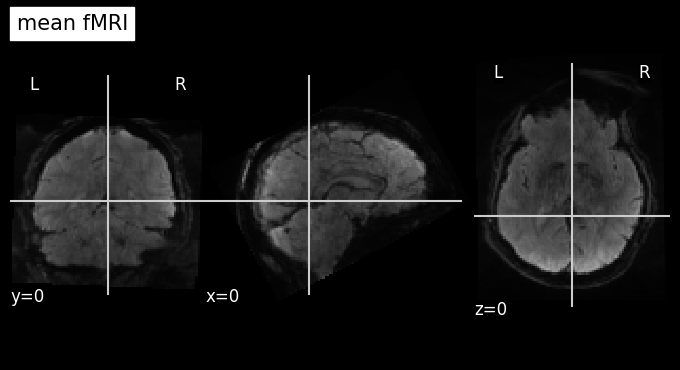

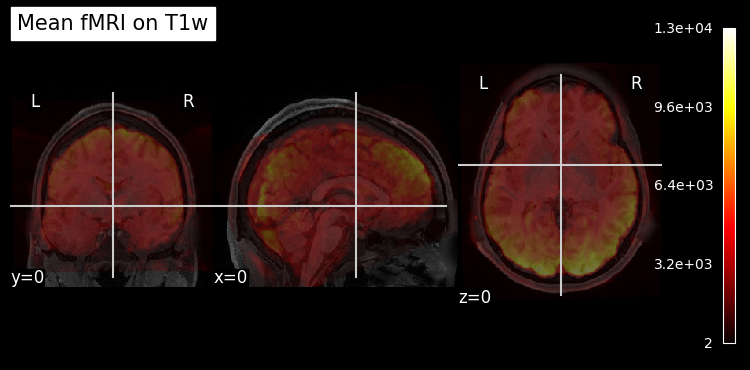

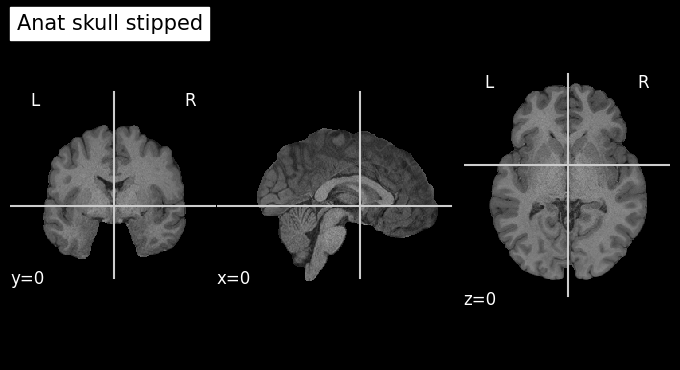

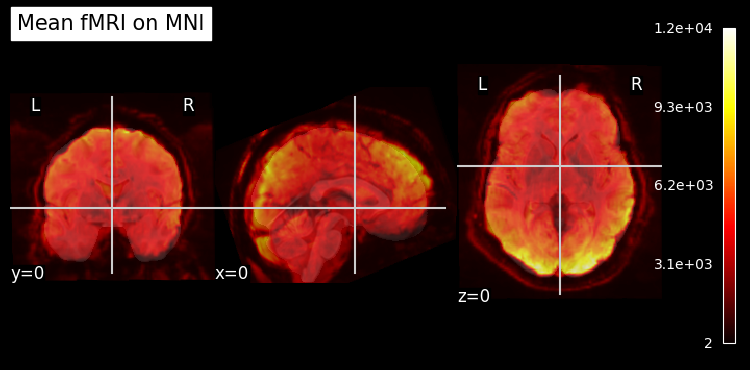

In [3]:
# To check transformations: for subject: (put this in different file)
# subjectid = '' 


output_dir = fr"D:\hcp_processed\{subjectid}\motion_corrected" 
registered_fmri_path = fr"{output_dir}\mean_fmri_registered_T1w.nii.gz"
mean_img_path = fr"{output_dir}\mean_fmri.nii.gz"
t1_path = fr"D:\hcp_data\{subjectid}\T1w\T1w_acpc_dc_restore.nii.gz"
registered_fmri_path_mni = fr"{output_dir}\mean_fmri_registered_mni.nii.gz"
mni_path = r"D:\Templates\mni_template.nii"

plotting.plot_anat(
    anat_img=mean_img_path,
    title="mean fMRI",
    display_mode='ortho',  # or 'x', 'y', 'z'
    cut_coords=(0, 0, 0),  # center coordinates, can be customized
    annotate=True
)

plotting.plot_stat_map(
    stat_map_img=registered_fmri_path,
    bg_img=t1_path,
    threshold=2,  # adjust based on intensity scale
    title="Mean fMRI on T1w",
    display_mode='ortho',
    cut_coords=(0, 0, 0),
    annotate=True,
    cmap="hot",
    alpha=0.3
)

plotting.show()

plotting.plot_anat(
    anat_img=t1_brain_output,
    title="Anat skull stipped",
    display_mode='ortho',  # or 'x', 'y', 'z'
    cut_coords=(0, 0, 0),  # center coordinates, can be customized
    annotate=True
)

plotting.plot_stat_map(
    stat_map_img=registered_fmri_path_mni,
    bg_img=mni_path,
    threshold=2,  # adjust based on intensity scale
    title="Mean fMRI on MNI",
    display_mode='ortho',
    cut_coords=(0, 0, 0),
    annotate=True,
    cmap="hot",
    alpha=0.7
)

plotting.show()




In [4]:
# pip install hd-bet


In [5]:
# import sys
# print(sys.executable)


In [6]:
# !pip show hd-bet
